# Hot Columns

There are some columns that are consistently "hot" in our CCD. We want to find those columns and remove them. We have code that does this with a "sigma-clipping" method and loops until stability. This code tries a Bayesian approach.

In [34]:
from astropy.table import Table
import numpy as np
import pymc3 as pm
import theano.tensor as T
from scipy import stats
import matplotlib.pyplot as plt


In [483]:
%config InlineBackend.figure_format = 'retina'
rng = np.random.default_rng()

In [484]:
comp = lambda a, b : print(set(a).difference(set(b)))

To test the code I spend some time creating "realistic" mock data. This includes:
  - Hot columns (hot_rate) with some probability (prob_hot)
  - Neighboring hot columns (neigh_rate) with some probability (prob_neigh) [TODO]

In [485]:
# CCD Dimensions and sample size
cols = 200
num_ims = 30

# Parameters to generate mock data
normal_rate = rng.normal(10, 1)
hot_rate = rng.normal(100, 10)
neigh_rate = rng.normal(15, 1)
prob_neigh = .6
prob_hot = .1

In [486]:
goodcols = set(np.arange(cols))

fdata = np.zeros((num_ims, cols))
pois_choice = rng.random(cols) > prob_hot
pois_lambda = np.zeros(cols)
pois_lambda[(pois_choice == True)] = normal_rate

hotcols = np.where(pois_choice == False)[0]
pois_lambda[hotcols] = hot_rate

neighbs = []

for i in hotcols:
    if rng.random() < prob_neigh:
        pois_lambda[i-1] = neigh_rate
        neighbs.append(i-1)

neighbs = np.array(neighbs)
# Generate mock
for i in range(num_ims):
    fdata[i] = rng.poisson(pois_lambda)
flat_data = np.mean(fdata, axis=0)
badcols = np.union1d(hotcols, neighbs)
sbc = set(badcols)
goodcols.difference_update(sbc)

In [487]:
# Originally we say that all columns are good columns
goodcols_guess = set(np.arange(cols))

### Sampler

In [488]:
# ys_obs = fdata[0]
ys_obs = flat_data

In [489]:
with pm.Model() as mix_lambda:
    lambda_good = pm.TruncatedNormal('lambda_good', mu=10, sigma=8)
    lambda_bad = pm.Lognormal('lambda_bad', mu=np.log(10), sigma=np.log(10))
    
    P_bad = pm.Beta('P_bad', alpha=1, beta=10)
    
    logp_good = T.log1p(-P_bad) + pm.Poisson.dist(lambda_good).logp(ys_obs)
    logp_bad = T.log(P_bad) + pm.Poisson.dist(lambda_bad).logp(ys_obs)

    log_odds = pm.Deterministic('log_odds', logp_good - logp_bad)
    _ = pm.Potential('likelihood', T.sum(pm.logaddexp(logp_good, logp_bad)))

In [490]:
with mix_lambda:
    mix_trace = pm.sample(draws=1000, tune=1000, chains=1, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [P_bad, lambda_bad, lambda_good]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/pecom/miniconda3/envs/astro/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


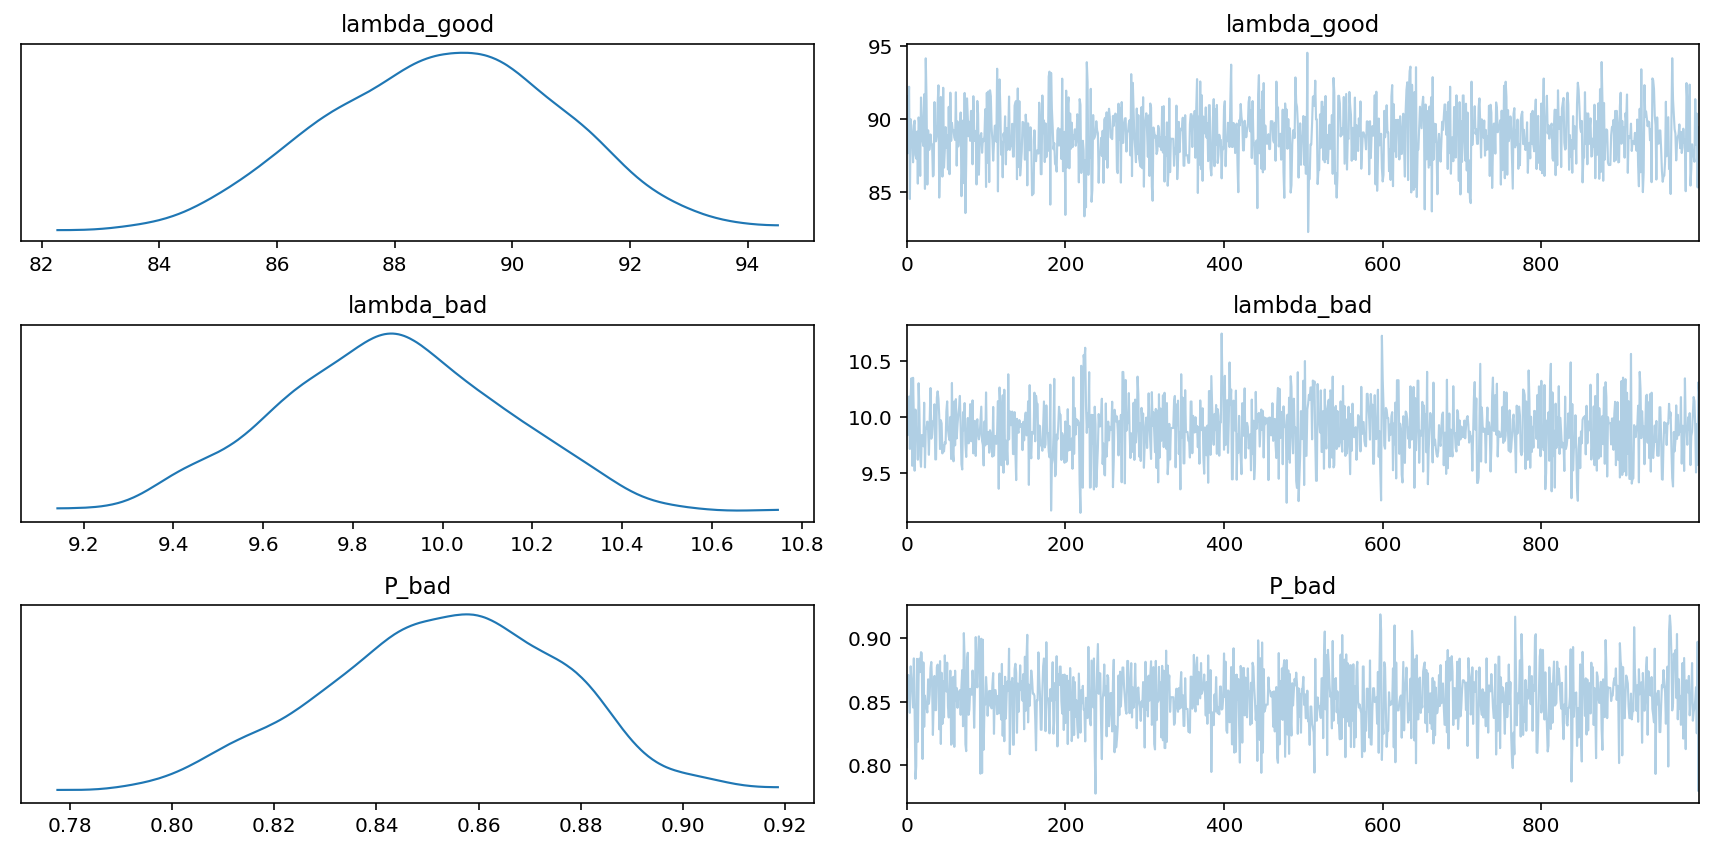

In [491]:
pm.plot_trace(mix_trace, var_names='~log_odds');
plt.tight_layout()

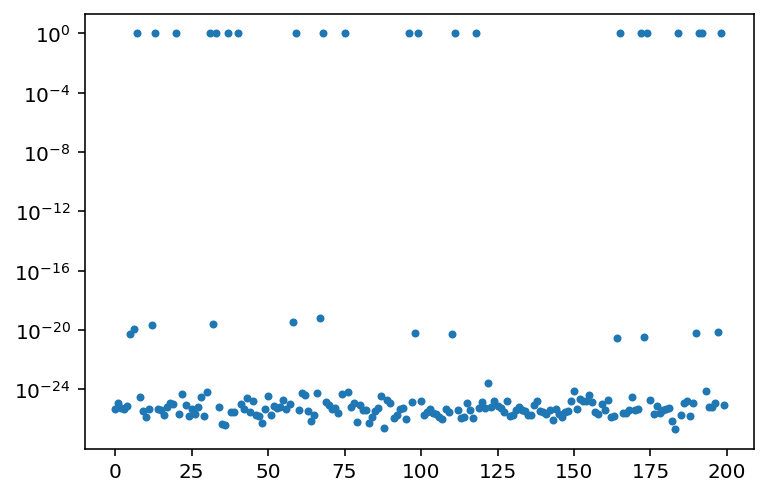

In [492]:
P_good = np.mean(1/(1+np.exp(-mix_trace['log_odds'])), axis=0)
plt.semilogy(P_good, '.')

#### Note: Sometimes lambda_good and lambda_bad can be swapped by swapping P_bad (degeneracy in naming), so be careful! For now we can look at the plot to determine the sign but we can also use the mean vs median type thing

We can help fix the degeneracy by comparing the solved lambdas for lambda_good and lambda_bad. Then we can calculate the correct P_good and choose the smaller one.

For this one it seems pretty easy to consistently set 1e-3 as the line but we might need some more funkiness to do this automatically.

In [493]:
bayesian_guesses_bad = np.where(P_good > 1e-3)[0]

In [494]:
good_lambda = np.median(mix_trace['lambda_good'])
bad_lambda = np.median(mix_trace['lambda_bad'])

In [495]:
set_bgb = set(bayesian_guesses_bad)

In [521]:
comp(badcols, bayesian_guesses_bad)
comp(hotcols, bayesian_guesses_bad)
comp(bayesian_guesses_bad, badcols) # This should be blank. We are not mislabelling any columns

{32, 98, 67, 164, 5, 6, 197, 12, 173, 110, 58, 190}
{6}
set()


In [497]:
print(badcols.shape)
print(bayesian_guesses_bad.shape)

(33,)
(21,)


In [498]:
# Remove the columns we are certain are hot
goodcols_guess.difference_update(set_bgb)

We aren't able to detect some of the hot columns! Now onto the next model

## Neighboring Columns
We know that columns next to clearly hot columns have a tendency to be hot as well. In the original code we would repeat sigma-clipping with a lower threshold for neighboring columns to cut them out more frequently. Depending on the difference between good columns and "hot neighbors" we may not have to change anything

We can try to be lazy as hell and use our derived good/bad rates and use that to label the neighboring columns. This should work if the difference between good columns and hot columns is large and/or we have a large number of samples.

In [499]:
# I wanted to do something lazy and avoid running a new run to determine which neighbors are good and which are bad, but it feels unavoidable


# baddies = []
# for c in check_neighs:
#     round_fd = np.round(flat_data[c])
#     good_prob = stats.poisson.pmf(round_fd, good_lambda)
#     bad_prob = stats.poisson.pmf(round_fd, bad_lambda)
#     if bad_prob > good_prob:
#         baddies.append(c)

#### Note: This is not as lazy as I was first hoping :( It seems easier to just use the same two model mixture.

I'm not crazy about this method of "remove the hot columns and then check again" since it feels a bit like the looping-till-stable method but I think it's not possible otherwise since we are breaking the assumption that each data point is independent which we need for our mc3 approach.

Some notes:
1. This should be caught in the 2-column or 3-column ... so I'm not sure how important it is to have this specific model
2. What we really want here is to see which columns are dependent on their neighbors. I'm not sure what statistical test we can use here but we shall find out!

In [508]:
check_neighs = []

# For each column that we are guessing is bad, check the nearby ones
for k in bayesian_guesses_bad:
    check_neighs += [k-1, k+1]
# check_neighs = np.array(list(set(check_neighs).difference(set_bgb)))   # Remove the actually very hot columns
check_neighs = np.array(list(set(check_neighs).difference(set_bgb)))
check_neighs = check_neighs[(check_neighs > 0) * (check_neighs < cols)]    # Deal with boundary issues for indexing (-1 isn't next to column 0...)

In [509]:
# neighb_obs = flat_data[np.array(list(goodcols_guess))]
neighb_obs = flat_data[check_neighs]

In [510]:
with pm.Model() as neighb_mix:
    lambda_good = pm.TruncatedNormal('lambda_good', mu=10, sigma=8)
    lambda_bad = pm.Lognormal('lambda_bad', mu=np.log(2), sigma=np.log(2))
    
    P_bad = pm.Beta('P_bad', alpha=1, beta=1)
    
    logp_good = T.log1p(-P_bad) + pm.Poisson.dist(lambda_good).logp(neighb_obs)
    logp_bad = T.log(P_bad) + pm.Poisson.dist(lambda_bad).logp(neighb_obs)

    log_odds = pm.Deterministic('log_odds', logp_good - logp_bad)
    _ = pm.Potential('likelihood', T.sum(pm.logaddexp(logp_good, logp_bad)))

In [511]:
with neighb_mix:
    neighb_trace = pm.sample(draws=1000, tune=1000, chains=1, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [P_bad, lambda_bad, lambda_good]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/pecom/miniconda3/envs/astro/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


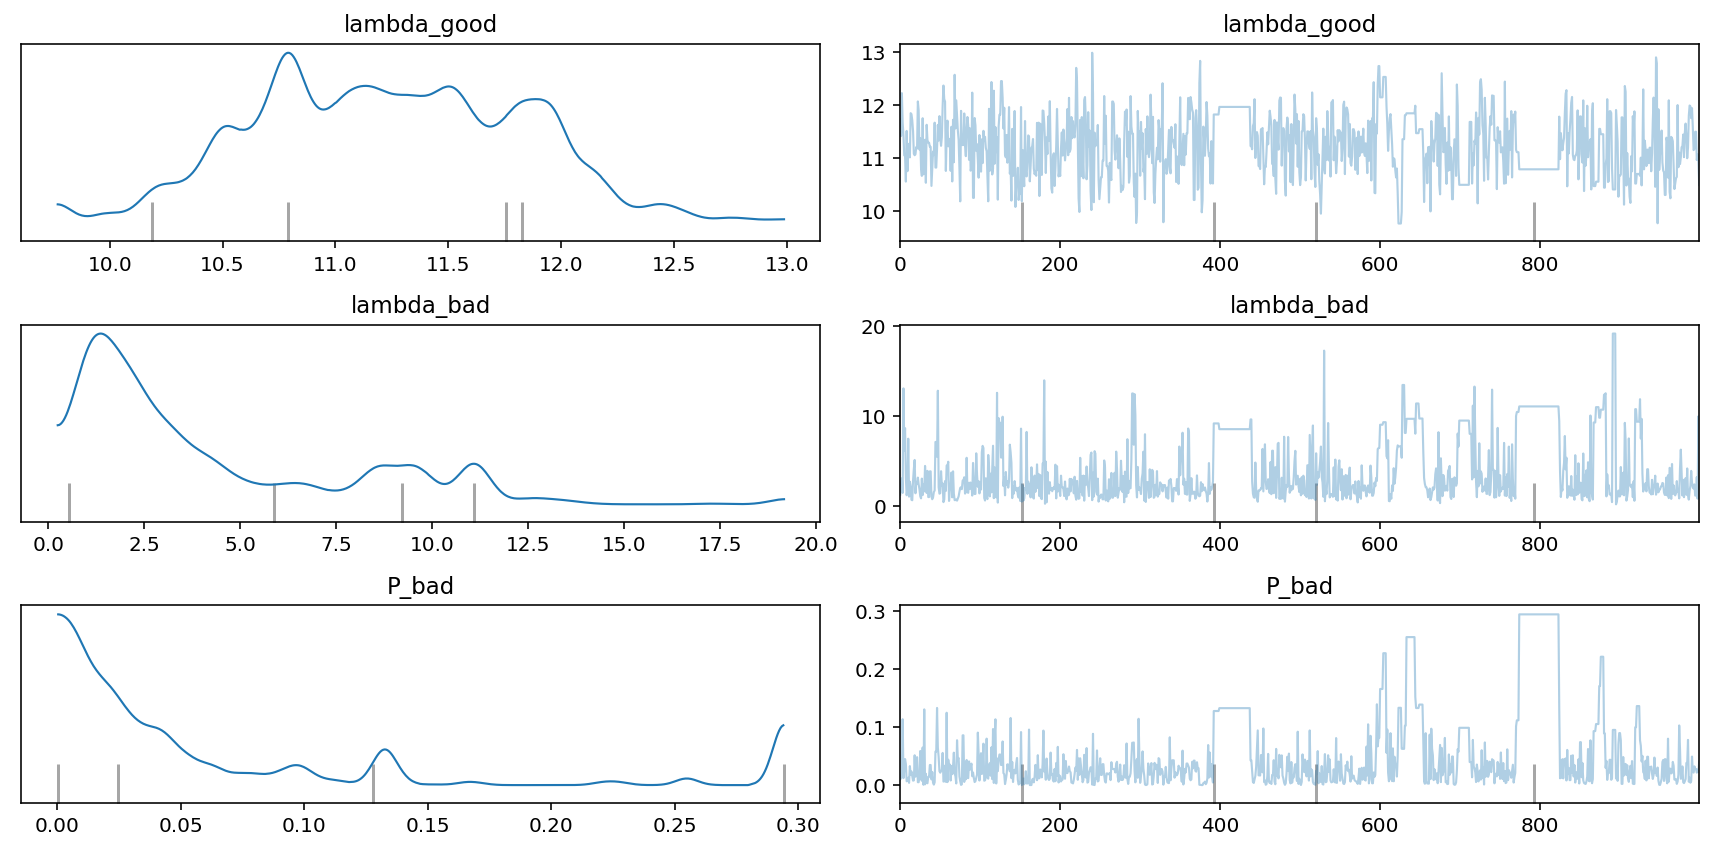

In [512]:
pm.plot_trace(neighb_trace, var_names='~log_odds');
# pm.plot_trace(neighb_trace);
plt.tight_layout()

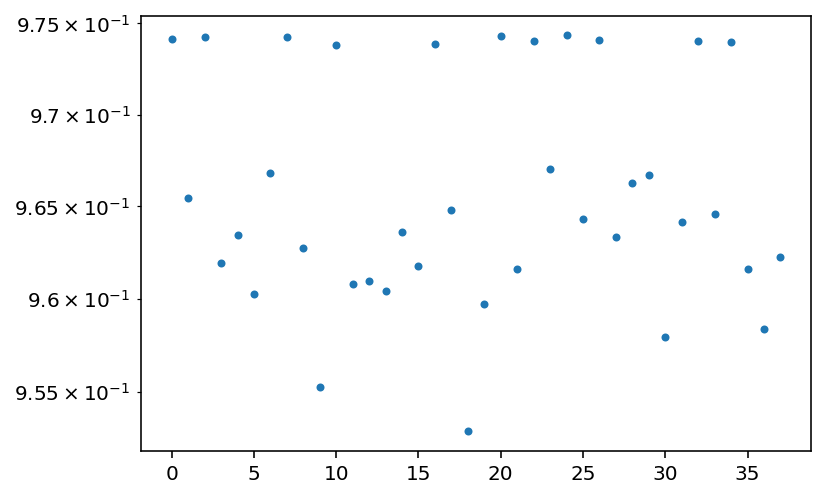

In [513]:
P_good_neigh = np.mean(1/(1+np.exp(-neighb_trace['log_odds'])), axis=0)
plt.semilogy(P_good_neigh, '.')

#### Once again we rely on graphics to tell us where the cutoff is

And we have the same naming degeneracy as last time. We don't have many samples for this method either so it seems a bit wacky.

In [514]:
neigh_cutoff = .97

In [515]:
comp(check_neighs[P_good_neigh > neigh_cutoff], neighbs)
comp(neighbs, check_neighs[P_good_neigh > neigh_cutoff])

set()
{5}


In [516]:
check_neighs[P_good_neigh > .96]

array([  6,   8,  12,  14,  19,  21,  30,  32,  34, 164,  38,  39, 166,
        41, 171, 173, 175,  58,  60, 190, 193,  67,  69, 197, 199,  74,
        76,  97,  98, 100, 110, 112, 119])

In [517]:
badcols

array([  5,   6,   7,  12,  13,  20,  31,  32,  33,  37,  40,  58,  59,
        67,  68,  75,  96,  98,  99, 110, 111, 118, 164, 165, 172, 173,
       174, 184, 190, 191, 192, 197, 198])

In [518]:
check_neighs

array([  6,   8,  12,  14,  19,  21,  30,  32,  34,  36, 164,  38,  39,
       166,  41, 171, 173, 175, 183, 185,  58,  60, 190, 193,  67,  69,
       197, 199,  74,  76,  95,  97,  98, 100, 110, 112, 117, 119])

In [520]:
hotcols

array([  6,   7,  13,  20,  31,  33,  37,  40,  59,  68,  75,  96,  99,
       111, 118, 165, 172, 174, 184, 191, 192, 198])

In [519]:
set_bgb

{7,
 13,
 20,
 31,
 33,
 37,
 40,
 59,
 68,
 75,
 96,
 99,
 111,
 118,
 165,
 172,
 174,
 184,
 191,
 192,
 198}

In [450]:
neighbs

array([  5,  54,  83,  93, 101, 102, 122, 132, 162, 171, 173])

# Issues:
  - I'm not certain how to incorporate the fact that we have multiple samples. 